# 查询、键和值

simply consider the following: denote by $D={(\mathbf{k}_1, \mathbf{v}_1), \ldots, (\mathbf{k}_m, \mathbf{v}_m)}$ a database of tuples of keys and values. Moreover, denote by $q$ a query. Then we can define the attention over $D$ as:

只需考虑以下内容：用 D = (k1, v1), ......, (Km， Vm) 表示由键值对组成的数据库。此外，用 q 表示一个查询。那么我们可以将 D 上的注意力定义为：

$$Attention(\mathbf{q}, \mathbf{D}) = \sum_{i=1}^m \alpha(\mathbf{q}, \mathbf{k}_i) \mathbf{v}_i,$$

where $\alpha(\mathbf{q}, \mathbf{k}_i) \in \mathbb{R}(i=1,...,m)$ is a scalar attention weights. The operation itself is typically referred to as attention pooling. The name attention derives from the fact that the operation pays particular attention to the terms for which the weight is significant (i.e., large). As such, the attention over $D$ generates a linear combination of values contained in the database. In fact, this contains the above example as a special case where all but one weight is zero. We have a number of special cases:

其中 a(q， k¿) ∈ R (i = 1， ... ， m) 是标量注意力权重。该操作本身通常被称为注意力池化。之所以称为注意力，是因为该操作特别关注显著的权重（即较大）的项。因此，D 上的注意力生成了数据库中值的线性组合。实际上，这包含了上述示例作为特殊情况，即除了一个权重外其余权重均为零。我们有许多特殊情况：

![image.png](../images/qkv_1.png)

A common strategy for ensuring that the weights sum up to is to normalize them via:

一种常见的确保权重总和为 1 的策略是通过以下方式对其进行归一化：

$$\alpha(\mathbf{q}, \mathbf{k}_i) = \frac{a(\mathbf{q}, \mathbf{k}_i)}{\sum_{j=1}^m a(\mathbf{q}, \mathbf{k}_j)}.$$

In particular, to ensure that the weights are also nonnegative, one can resort to exponentiation. This means that we can now pick any function $\alpha(\mathbf{q}, \mathbf{k})$ and then apply the softmax operation used for multinomial models to it via：

特别地，为了确保权重也为非负，可以采用指数化。这意味着我们现在可以选择任何函数 o(q， k)，然后通过应用于多项式模型的 softmax 操作对其进行处理，即：

$$\alpha(\mathbf{q}, \mathbf{k}_i) = \mathrm{softmax}(a(\mathbf{q}, \mathbf{k}_i)) = \frac{\exp(a(\mathbf{q}, \mathbf{k}_i))}{\sum_{j=1}^m \exp(a(\mathbf{q}, \mathbf{k}_j))}.$$

This operation is readily available in all deep learning frameworks. It is differentiable and its gradient never vanishes, all of which are desirable properties in a model. Note though, the attention mechanism introduced above is not the only option. For instance, we can design a non-differentiable attention model that can be trained using reinforcement learning methods (Mnih et al., 2014). As one would expect, training such a model is quite complex. Consequently the bulk of modern attention research follows the framework outlined in Fig. 11.1.1. We thus focus our exposition on this family of differentiable mechanisms.

此操作在所有深度学习框架中都很容易实现。它是可微的，其梯度永远不会消失，这些都是模型的理想属性。不过需要注意的是，上文介绍的注意力机制并非唯一的选择。例如，我们可以设计一种不可微的注意力模型，使用强化学习方法对其进行训练（Mnih 等人，2014 年）。正如人们所料，训练这样的模型相当复杂。因此，现代注意力机制研究的大部分内容都遵循下图 11.1.1 所概述的框架。因此，我们主要关注这一类可微机制。

![11.1.1](../images/qkv.png)

The attention mechanism computes a linear combination over values $v_i$ via attention pooling, where weights are derived according to the compatibility between a query $q$ and keys $k_i$

注意力机制通过注意力池化操作对值 $v_i$ 进行加权求和，权重由查询向量 $q$ 与各键向量 $k_i$ 之间的兼容性程度决定。
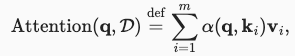
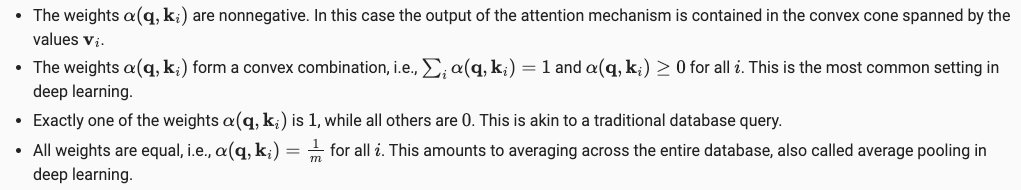

## 注意力的可视化

In [45]:
import torch
from d2l import torch as d2l

One of the benefits of the attention mechanism is that it can be quite intuitive, particularly when the weights are nonnegative and sum to
. In this case we might interpret large weights as a way for the model to select components of relevance. While this is a good intuition, it is important to remember that it is just that, an intuition. Regardless, we may want to visualize its effect on the given set of keys when applying a variety of different queries. This function will come in handy later.

注意力机制的一个优点在于它往往相当直观，尤其是当权重为非负且总和为 1 时。在这种情况下，我们或许可以将较大的权重视为模型选择相关成分的一种方式。尽管这是一种不错的直觉，但重要的是要记住，这仅仅是一种直觉。不管怎样，我们可能希望在应用各种不同的查询时，可视化其对给定键集的影响。这个函数稍后会派上用场。

We thus define the show_heatmaps function. Note that it does not take a matrix (of attention weights) as its input but rather a tensor with four axes, allowing for an array of different queries and weights. Consequently the input matrices has the shape (number of rows for display, number of columns for display, number of queries, number of keys). This will come in handy later on when we want to visualize the workings that are to design Transformers.

因此，我们定义了 `show_heatmaps` 函数。请注意，它并非以矩阵（注意力权重矩阵）作为输入，而是接受一个具有四个轴的张量，从而能够处理不同查询和权重的数组。因此，输入矩阵的形状为（用于显示的行数，用于显示的列数，查询数量，键的数量）。这在之后我们想要可视化设计 Transformer 的工作原理时会很有用。


In [46]:
#@save
def show_heatmaps(matrices, xlabel, ylabel, titles=None, figsize=(2.5, 2.5),
                  cmap='Reds'):
    """显示矩阵热图"""
    d2l.use_svg_display()
    num_rows, num_cols = matrices.shape[0], matrices.shape[1]
    fig, axes = d2l.plt.subplots(num_rows, num_cols, figsize=figsize,
                                 sharex=True, sharey=True, squeeze=False)
    for i, (row_axes, row_matrices) in enumerate(zip(axes, matrices)):
        for j, (ax, matrix) in enumerate(zip(row_axes, row_matrices)):
            pcm = ax.imshow(matrix.detach().numpy(), cmap=cmap)
            if i == num_rows - 1:
                ax.set_xlabel(xlabel)
            if j == 0:
                ax.set_ylabel(ylabel)
            if titles:
                ax.set_title(titles[j])
    fig.colorbar(pcm, ax=axes, shrink=0.6);

下面使用一个简单的例子进行演示。
在本例子中，仅当查询和键相同时，注意力权重为1，否则为0。


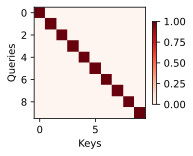

In [47]:
attention_weights = torch.eye(10).reshape((1, 1, 10, 10))
show_heatmaps(attention_weights, xlabel='Keys', ylabel='Queries')

## 小结

The attention mechanism allows us to aggregate data from many (key, value) pairs. So far our discussion was quite abstract, simply describing a way to pool data. We have not explained yet where those mysterious queries, keys, and values might arise from. Some intuition might help here: for instance, in a regression setting, the query might correspond to the location where the regression should be carried out. The keys are the locations where past data was observed and the values are the (regression) values themselves. This is the so-called Nadaraya–Watson estimator (Nadaraya, 1964, Watson, 1964) that we will be studying in the next section.

注意力机制使我们能够从许多（键，值）对中聚合数据。到目前为止，我们的讨论相当抽象，只是描述了一种汇集数据的方法。我们尚未解释那些神秘的查询、键和值可能从何而来。这里一些直觉可能会有所帮助：例如，在回归设置中，查询可能对应于应执行回归的位置。键是过去数据被观察到的位置，值则是（回归）值本身。这就是被称为 Nadaraya–Watson 的评估器（纳达拉亚，1964 年，沃森，1964 年），我们将在下一节对其进行研究。

By design, the attention mechanism provides a differentiable means of control by which a neural network can select elements from a set and to construct an associated weighted sum over representations.

通过设计，注意力机制提供了一种可微分的控制手段，借此神经网络可以从一组元素中进行选择，并构建与之相关的加权表示总和。